In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
from numpy import inf
%matplotlib inline

In [36]:
credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")


# The Dataset

For my capstone, I will be exploring the the TMDB Movie Dataset from The Movie Database (__[Kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata/data)__). It contains information for nearly 5,000 films, dating as far back as 1916, and includes data pertaining to to release date, budget, genre, popularity ratings, cast & crew, etc. 

With so many films being produced and released each year, it has become important to use associated data in order to measure and predict success. Is there a particular genre that performs better than others, in terms or revenue, ratings, return etc.? Are there actors that perform better than others? Is there any meaningful difference between different actors, genres, or production companies? These questions make it possible to assign value to a film, and can even be used to predict success of future films, and inform the industry about what types of movies should be produced. 

# Understanding the Data

There are two csv files, one for movies and one for credits. I will want to combine the datasets, so I can easily take a look at all desired fields, focusing primarily on actors and genres, in the lens of budget, revenue, and return. 

The data set contains 20 unique genres (genre_1) and 1300 unique actors listed as top billed (actor_1), that I will be working with. As a caveat to the following exploration and analysis, I will be assuming that the first actor listed in the cast field is the top billed actor for a given film (which does appear to be the case). 
For genre, while I will be classifying by genre 1, 2, or 3, a movie can have multiple genres associated with it, and genre 1 should not necesarily mean it is the primary genre. For the purpose of this capstone, I will only be using the first genre listed, but can explore this matter more for future analysis. 

To begin, I will take a look at the size and structure of my two csv files. 


In [3]:
print(credits.shape)
print(movies.shape)

print('\n')
print(credits.loc[0,:])
print('\n')
print(movies.loc[0,:])

(4803, 4)
(4803, 20)


movie_id                                                19995
title                                                  Avatar
cast        [{"cast_id": 242, "character": "Jake Sully", "...
crew        [{"credit_id": "52fe48009251416c750aca23", "de...
Name: 0, dtype: object


budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                        150.438
production_companies    [{"name": "Ing

Looks like were are dealing with a comibation of different object types. I am most interested in looking at genres and actors, which are stored in strings containing key value pairs (JSON objects most likely). Let's confirm. 

In [4]:
type(credits.cast[0])

str

So in order to pull out the genres and actors from the strings, lets apply JSON loads to parse these so we can use the columns like a normal dictionary, and then combine the two files into one data frame. Additionally, I will have to deal with missing values so an error is not returned when combining the files. 


In [37]:
def index_key_fix(colval, index_val):
    # return missing value rather than an error upon indexing/key failure
    result = colval
    try:
        for ind in index_val:
            result = result[ind]
        return result
    except IndexError or KeyError:
        return pd.np.nan
    
def delimit_tmdb_movies(file):
    df = pd.read_csv(file)
    json_columns = ['genres']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def delimit_tmdb_credits(file):
    df = pd.read_csv(file)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

#here i am pulling out the desired actor and genre fields I am interested in.
def combine_df(movies, credits):
    tmdb_500_movies = movies.copy()
    tmdb_500_movies['actor_1'] = credits['cast'].apply(lambda x: index_key_fix(x, [0, 'name']))
    tmdb_500_movies['actor_2'] = credits['cast'].apply(lambda x: index_key_fix(x, [1, 'name']))
    tmdb_500_movies['actor_3'] = credits['cast'].apply(lambda x: index_key_fix(x, [2, 'name']))
    tmdb_500_movies['genre_1'] = tmdb_500_movies['genres'].apply(lambda x: index_key_fix(x, [0, 'name']))
    tmdb_500_movies['genre_2'] = tmdb_500_movies['genres'].apply(lambda x: index_key_fix(x, [1, 'name']))
    tmdb_500_movies['genre_3'] = tmdb_500_movies['genres'].apply(lambda x: index_key_fix(x, [2, 'name']))
    return tmdb_500_movies

#Time to combine into one dataframe
credits = delimit_tmdb_credits("tmdb_5000_credits.csv")
movies = delimit_tmdb_movies("tmdb_5000_movies.csv")
df_combine = combine_df(movies, credits)


In [6]:
#Let's take a look at our new dataframe.
print(df_combine.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 26 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [38]:
#I know that there are many instances of zero values for budget and revenue.
#I want to replace 0 values with nan for budget and revenue, and will caveat that these were most likely 
#smaller movies in the first place.
#I also want to make them both into floats. 

df_combine['revenue'] = pd.to_numeric(df_combine['revenue'], errors='coerce').astype(float)
df_combine['budget'] = pd.to_numeric(df_combine['budget'], errors='coerce').astype(float)
df_combine['revenue'] = df_combine['revenue'].replace(0,np.nan)
df_combine['budget'] = df_combine['budget'].replace(0,np.nan)

#Note, there are movies with null values for revenue that have a value for budget, and vice-versa.
#When I calculate return, I will only use films that have non-null values for both budget and revenue. 

#I also want to replace missing values for actors and genres with nan.
df_combine['actor_1'] = df_combine['actor_1'].replace(0,np.nan)
df_combine['actor_2'] = df_combine['actor_2'].replace(0,np.nan)
df_combine['actor_3'] = df_combine['actor_3'].replace(0,np.nan)
df_combine['genre_1'] = df_combine['genre_1'].replace(0,np.nan)
df_combine['genre_2'] = df_combine['genre_2'].replace(0,np.nan)
df_combine['genre_3'] = df_combine['genre_3'].replace(0,np.nan)

Before I go into the questions, I want to get a sense of the top movies, in terms of gross
There will likely be big Blockbuster movies that have the potential of skewing my results, so I want to get a sense of what they are. 

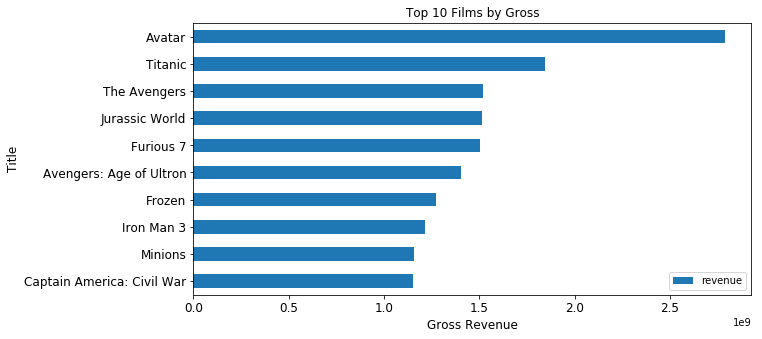

In [41]:
top_grossing_films = df_combine[['title','revenue']]
top_grossing_films = top_grossing_films.sort_values('revenue', ascending=False).head(10)

top_grossing_films.plot.barh(x=['title'], y=['revenue'])
plt.xlabel('Gross Revenue')
plt.ylabel('Title')
plt.title("Top 10 Films by Gross")
plt.rc('axes', labelsize=12)
plt.rc('ytick', labelsize=12) 
plt.xticks(fontsize=12)
plt.rcParams["figure.figsize"] = (10,5)
plt.gca().invert_yaxis()
plt.show()

# The Questions

1. What is the average revenue and budget for the films in the dataset? How is the data for revenue and budget distributed?
2. What are the most common genres, and is there any meaningful significance between these genres? Also how does the revenue, budget, and more importantly, return, compare between the genres in the data set? 
3. Which actors have the most starring roles? For the top 25 most appearing actors, which actors have the highest average gross and return? 

# Question 1:  What is the average revenue and budget for the films in the dataset? How is the data for revenue and budget distributed?

Since I will be looking primarily at budget and revenue, I want to take a look at the descritive statistics for these metrics. 
I know that the values for budget and revenue are quite large, as seen by the top titles bar chart.
I will divide by 10e+6 to make them into millions, and rename the columns for clarity.

In [10]:
df_combine.loc[:,'budget'] = round((df_combine['budget'] /10**6),2)
df_combine.loc[:,'revenue'] = round((df_combine['revenue'] /10**6),2)
df_combine =df_combine.rename(columns={'budget':'budget_M','revenue':'revenue_M'})

print('The descriptive statistics for budget (in M) are:')
print(df_combine.budget_M.describe())
print('\n')
print('The descriptive statistics for revenue (in M) are:')
print(df_combine.revenue_M.describe())

#I also want to calculate variance
print('\n')
print('The variance in budget is: {}'.format(round(df_combine.budget_M.var(ddof=1),2)))
print('The variance in revenue is: {}'.format(round(df_combine.revenue_M.var(ddof=1),2)))

The descriptive statistics for budget (in M) are:
count    3766.000000
mean       37.042839
std        42.646517
min         0.000000
25%         8.000000
50%        23.000000
75%        50.000000
max       380.000000
Name: budget_M, dtype: float64


The descriptive statistics for revenue (in M) are:
count    3376.000000
mean      117.031315
std       183.483122
min         0.000000
25%        15.352500
50%        51.750000
75%       140.165000
max      2787.970000
Name: revenue_M, dtype: float64


The variance in budget is: 1818.73
The variance in revenue is: 33666.06


OK, so based on the statistics above, the average budget for the 4K+ movies in the data set is 37M, while the average revenue is 117M. Just looking at the statistics, the median budget and median revenue are lower than their respective means, likely indicating some skew in the distribution of the data for each metric. 

Additionally, one can see that the standard deviation and the range of each distribution are considerably large, indicating there is lot of variance in budget and revenue (which is confirmed by the above calculations) . This is likely due the presence of outliers (in each direction).

I want to see what the distributions look like and check for normality by plotting some histrograms.  

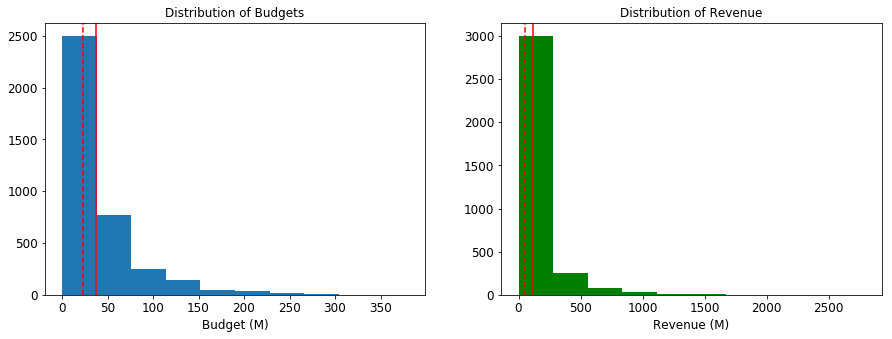

In [33]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(df_combine['budget_M'].dropna())
plt.xlabel('Budget (M)')
plt.title('Distribution of Budgets')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

#let's add the median and mean lines to the histogram
plt.axvline(df_combine['budget_M'].mean(), color='r',linestyle='solid')
plt.axvline(df_combine['budget_M'].median(), color='r',linestyle='dashed')

plt.subplot(1,2,2)
plt.hist(df_combine['revenue_M'].dropna(),color='g')
plt.xlabel('Revenue (M)')
plt.title('Distribution of Revenue')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.axvline(df_combine['revenue_M'].mean(), color='r',linestyle='solid')
plt.axvline(df_combine['revenue_M'].median(), color='r',linestyle='dashed')

plt.show()


The above histograms show that there is clearly some (right skew) with long tails likely containing outliers, which pull the means of each distribution away from the medians. This indicates the the distributions for each might not be normal.
It's important to note that just because a distribution of data has outliers, does not necesarily mean it is not normally distributed, but let's investigate more with boxplots and QQ plots. 


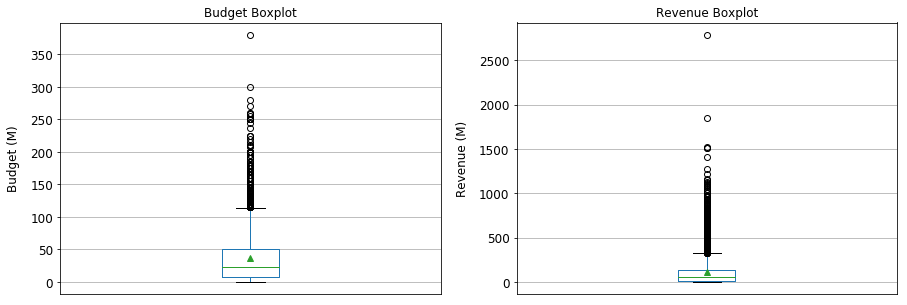

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
df_combine[['budget_M']].boxplot(showmeans=True)
plt.title('Budget Boxplot')
plt.ylabel('Budget (M)', labelpad=10)
plt.xticks([])
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
df_combine[['revenue_M']].boxplot(showmeans=True)
plt.title('Revenue Boxplot')
plt.ylabel('Revenue (M)', labelpad=10)
plt.xticks([])
plt.yticks(fontsize=12)
plt.show()

These boxplots mirror what I saw in the histograms. The IQR of each are realively small compared to the range of total values, and there clearly are fliers in each of the revenue and budget variables. Let's acutally calculate the % of films that have fliers that lie above the upper tails, and the % of total revenue and budget that these films make up.  

In [13]:
budget_q1 = df_combine['budget_M'].quantile(0.25)
budget_q3 = df_combine['budget_M'].quantile(0.75)
budget_iqr = budget_q3 - budget_q1
revenue_q1 = df_combine['revenue_M'].quantile(0.25)
revenue_q3 = df_combine['revenue_M'].quantile(0.75)
revenue_iqr = revenue_q3 - revenue_q1

upper_budget_sum = (df_combine[df_combine['budget_M']>(budget_q3 + (budget_iqr*1.5))]['budget_M'].sum())/ \
                                                                df_combine['budget_M'].sum()
upper_rev_sum = (df_combine[df_combine['revenue_M']>(revenue_q3 + (revenue_iqr*1.5))]['revenue_M'].sum())/ \
                                                                df_combine['revenue_M'].sum()
upper_budget_count = (df_combine[df_combine['budget_M']>(budget_q3 + (budget_iqr*1.5))]['budget_M'].count())/ \
                                                                df_combine['budget_M'].count()
upper_rev_count = (df_combine[df_combine['revenue_M']>(revenue_q3 + (revenue_iqr*1.5))]['revenue_M'].count())/ \
                                                                df_combine['revenue_M'].count()

print('The upper fliers in budget represent {:.2%} of total films'.format(upper_budget_count))
print('The upper fliers in revenue represent {:.2%} of total films'.format(upper_rev_count))
print('The upper fliers in budget make up {:.2%} of total film budgets'.format(upper_budget_sum))
print('The upper fliers in revenue make up {:.2%} of total film revenues'.format(upper_rev_sum))


The upper fliers in budget represent 6.51% of total films
The upper fliers in revenue represent 8.86% of total films
The upper fliers in budget make up 28.39% of total film budgets
The upper fliers in revenue make up 44.39% of total film revenues


While these films make up less than 10% of total films, for both budget and revenue, the fliers in budget make up 28% percent of the total budget sum, and the fliers in revenue make up 44% of the total revenue sum. In this context, it makes more sense that the means in each distribution diverge from the medians. 

The above plots and calculations lead me to further beleive that the distributions in revenue and budget are not normal, but I want to do one final check with a QQ plot. 

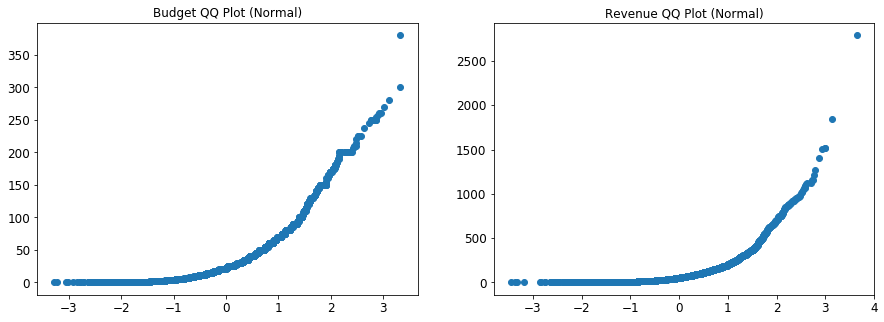

In [30]:
#First I will compare against normal distributions with a mean of 0 and standard deviation of 1
budget_dist = df_combine[df_combine['budget_M'].notnull()]['budget_M'].values
norm_budget = np.random.normal(0, 1, len(df_combine['budget_M'].dropna()))  
revenue_dist = df_combine[df_combine['revenue_M'].notnull()]['revenue_M'].values
norm_revenue= np.random.normal(0, 1, len(df_combine['revenue_M'].dropna())) 

budget_dist.sort()
norm_budget.sort()
revenue_dist.sort()
norm_revenue.sort()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(norm_budget, budget_dist, 'o')
plt.title('Budget QQ Plot (Normal)')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.subplot(1,2,2)
plt.plot(norm_revenue, revenue_dist, 'o')
plt.title('Revenue QQ Plot (Normal)')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

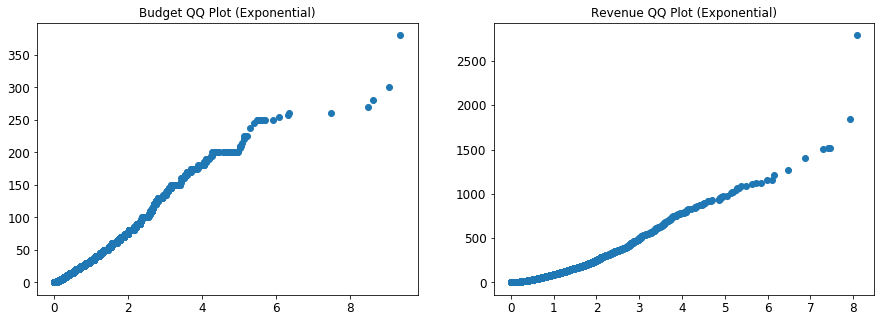

In [29]:
#From these QQ plots , there is more evidence that the values of my budget and revenue varaibles 
#are likely not normally distributed.
#The shape of the histograms almost resemble an exponential distribution. 
#I want to check this with a QQ plot, plotting against an exponentially distributed variable with a scale of 1. 

budget_dist = df_combine[df_combine['budget_M'].notnull()]['budget_M'].values
exp_budget = np.random.exponential(1, len(df_combine['budget_M'].dropna())) 
revenue_dist = df_combine[df_combine['revenue_M'].notnull()]['revenue_M'].values
exp_revenue= np.random.exponential(1, len(df_combine['revenue_M'].dropna())) 

budget_dist.sort()
exp_budget.sort()
revenue_dist.sort()
exp_revenue.sort()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(exp_budget, budget_dist, 'o')
plt.title('Budget QQ Plot (Exponential)')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.subplot(1,2,2)
plt.plot(exp_revenue, revenue_dist, 'o')
plt.title('Revenue QQ Plot (Exponential)')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

The QQ above shows a fairly straight line for both budget and revenue when plotted against an exponentially distributed variable, which leads me to further believe that the distributions are likely non-normal. For future research, I would want to look into ways of normalizing this data and dealing with the outliers/type of distribution, as well as the implications of using non-normally distributed data. 

Moving forward, I will continue to look at the means of the revenue and budget distributions, (as I still want to consider the big blockbuster films),  but with the understanding that they are likely means of a non-normal distribution. 


# Question 2- What are the most common genres, and is there any meaningful significance between these genres?Also how does the revenue, budget and more importantly, return, compare between the genres in the data set? 

As I mentioned previously, I will be using the first genre listed in the genre field of the data set. Films can have multiple genres, however, so the first genre is not necesarily the primary genre. For example, Comedy films can have elements of Fantasy or Science-Fiction--genres that might actually better describe the type of film it is. I will continue to use genre 1, but I might want to take a look at all the genres associated with a given film in the future. 

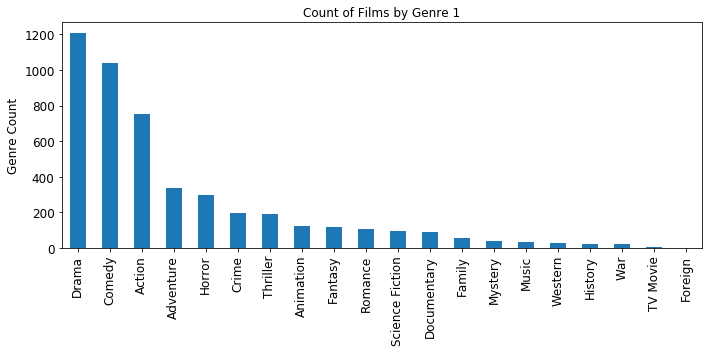

In [28]:
#Let's start by looking at the count, by genre
plt.figure(figsize=(10,5))
df_combine['genre_1'].value_counts().plot(kind='bar')
plt.title('Count of Films by Genre 1')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Genre Count')
plt.tight_layout()
plt.show()

As a primary genre, Drama films have the highest count, followed by Comedy and Action films. This is not totally surprising considering these are pretty broad genre descriptions, but also very popular. You can see that the more specific genres like Western or War make up much less. 

Before I compare the budget, revenue, and return of all genres, I want to take a quick look to see if there is any meaningful significance between the most common genres, Drama and Comedy, using a t-test. I will use return as my metric of interest (which I need to calculate) to compare my Drama and Comedy samples. 

In [17]:
def get_clean_returns(df,genre_name):
    df_genre_return= df[df['genre_1']==genre_name][['budget_M','revenue_M']] 
    #remove any films that have null values in either budget or revenue, before my division
    df_genre_return = df_genre_return[(df_genre_return['budget_M'].notnull()) \
                & (df_genre_return['revenue_M'].notnull())][['budget_M','revenue_M']].reset_index()
    df_genre_return['return'] = df_genre_return['revenue_M']/df_genre_return['budget_M']
    #I want to account for inf values, so they are not returned in my arrays
    df_genre_return[df_genre_return['return'] == inf] = 0
    df_genre_return['return'].replace(0,np.nan)
    df_genre_return = df_genre_return.drop(['index','revenue_M','budget_M'],axis=1)
    #creating my arrays
    array_genre_return =df_genre_return.iloc[:,0].values
    array_genre_return = array_genre_return[~np.isnan(array_genre_return)]
    return array_genre_return

#Using my function, I can specify the genres I want as my input
array_comedy_return = get_clean_returns(df_combine,'Comedy')
array_drama_return = get_clean_returns(df_combine,'Drama')

#Now I can run the ttest
from scipy.stats import ttest_ind
print(ttest_ind(array_drama_return, array_comedy_return, equal_var=False))

Ttest_indResult(statistic=0.68706380357258023, pvalue=0.49218536174576766)


Based on the above ttest, and the pvalue, I cannot reject my null hypothesis, that the mean returns of my Drama and Comedy samples are the same. Given the small t-value, the means of my samples are less than 1 standard errors apart. Differences in the means of the samples are likely just due to variability between them, and not a meaningful difference in populations. 

This makes sense, considering these are very broad genre categories, and there is likely some overlap in films (i.e. films that have both comedy and drama listed as genres in the data set). For future work, I can look at genres that are less similar, or I can look at other metrics, such as revenue, or even popularity scores. 

Now, I want to get back to my full list of genres, and compare revenue, budget, and return. 

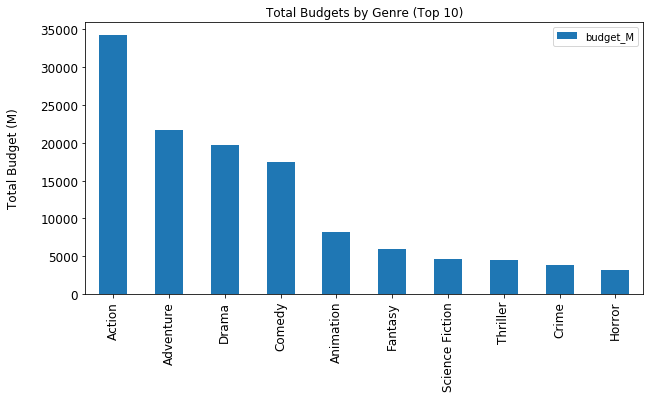

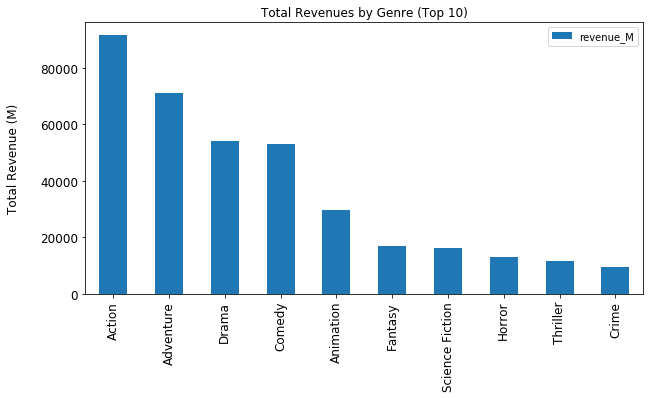

In [27]:
#Per the logic of the function above, I only want to look at films that have
#non-null values for both revenue and budget. 
#I am going to make a new dataframe to reflect this, that I can use moving forward. 
df_clean_RB= df_combine[(df_combine['budget_M'].notnull()) & (df_combine['revenue_M'].notnull())]

#let's start by looking at total revenue and budget, limiting to the top 10 genres by budget and revenue
rev_col = ['revenue_M']
budget_col = ['budget_M']
df_genre_rev_sum = pd.DataFrame(df_clean_RB.groupby('genre_1')['revenue_M'].sum().dropna())
df_genre_rev_sum = df_genre_rev_sum.sort_values('revenue_M', ascending =False).head(10)
df_genre_budget_sum = pd.DataFrame(df_clean_RB.groupby('genre_1')['budget_M'].sum().dropna())
df_genre_budget_sum = df_genre_budget_sum.sort_values('budget_M', ascending =False).head(10)

df_genre_budget_sum.plot.bar(y =budget_col)
plt.title("Total Budgets by Genre (Top 10)")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Total Budget (M)", labelpad=20)
plt.xlabel('')
plt.show()

df_genre_rev_sum.plot.bar(y =rev_col)
plt.title("Total Revenues by Genre (Top 10)")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Total Revenue (M)", labelpad=20)
plt.xlabel('')
plt.show()

This makes sense, given the pure volume of Action and Adventure movies and their status as a 'Blockbuster' type genre.
However, given the range in genre counts, I am more interested in looking at average revenue and budget. 

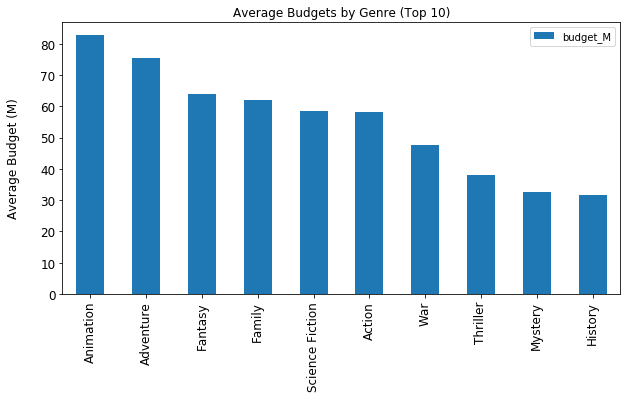

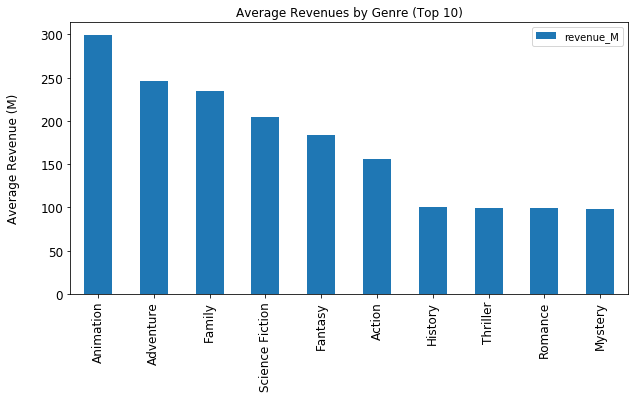

In [43]:
budget_col = ['budget_M']
df_genre_budget_avg = pd.DataFrame(df_clean_RB.groupby('genre_1')['budget_M'].mean().dropna())
df_genre_budget_avg = df_genre_budget_avg.sort_values('budget_M', ascending =False).head(10)
df_genre_budget_avg.plot.bar(y =budget_col)
plt.title("Average Budgets by Genre (Top 10)")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Average Budget (M)", labelpad=20)
plt.xlabel('')

budget_col = ['revenue_M']
df_genre_rev_avg = pd.DataFrame(df_clean_RB.groupby('genre_1')['revenue_M'].mean().dropna())
df_genre_rev_avg= df_genre_rev_avg.sort_values('revenue_M', ascending =False).head(10)
df_genre_rev_avg.plot.bar(y =budget_col)
plt.title("Average Revenues by Genre (Top 10)")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Average Revenue (M)", labelpad=20)
plt.xlabel('')

plt.show()

From the plots, we can see that Animation and Adventure films are actually the most expensive, and highest grossing films on average, which makes sense considering the high-concept, highly technical nature of these genres. 
Also, these plots show that while Drama and Comedy are the most common genres, they have relatively low average budgets and gross (neither are in the top 10), compared to other common genres. 

To really understand the tradeoff between budget and revenue, however, I will need to look at the return, which will show the true value received from a given genre.

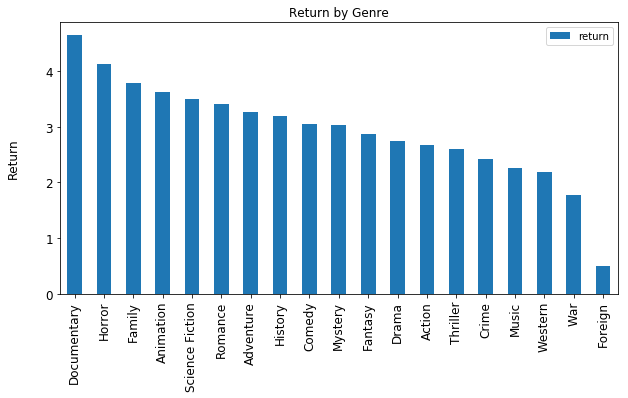

The average return of the films in the data set is: 2.98


In [42]:
df_genre_return = pd.DataFrame(df_clean_RB.groupby('genre_1')['budget_M','revenue_M'].sum().dropna())
df_genre_return['return']=df_genre_return['revenue_M']/df_genre_return['budget_M']

cols = ['return']
df_genre_return = df_genre_return.sort_values('return', ascending =False)
df_genre_return.plot.bar(y =cols)
plt.ylabel('Return', labelpad=25)
plt.title("Return by Genre")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.show()

avg_return=round(df_genre_return['revenue_M'].sum()/df_genre_return['budget_M'].sum(),2)  
print('The average return of the films in the data set is: {}'.format(avg_return))


This is very interesting. The genres with the top returns, Documentary and Horror, had fairly low average budgets and revenues, while the return for the most common genre, Drama, fell below the average return.
Even lower than that, Action films only have an average return of 2.67, despite having a collective gross of 91 billion dollars. 

Additionally, you can see that Animation and Family films, which are among the highest grossing genres, on average, also have strong return on the dollar. 

The above shows that being of genre that tends to be high grossing, does not always translate into returns. In fact, we can see that being a less common, or more specialized genres like Horror or Sci-Fi, may actually result in a higher return. However, films of these genres are likely to gross less overall. 

There are other factors that could attribute to the returns that we see, such as the average popularity or ratings score of a particular genre. Additionally, given the large variance in the distributions for budget and revenue, my results are likely being skewed by the the presence of outliers. I illustrate this below, looking specifically at the distributions of revenue by genre. In the future, I might want to look into adjusting for the range and variance in the data. 

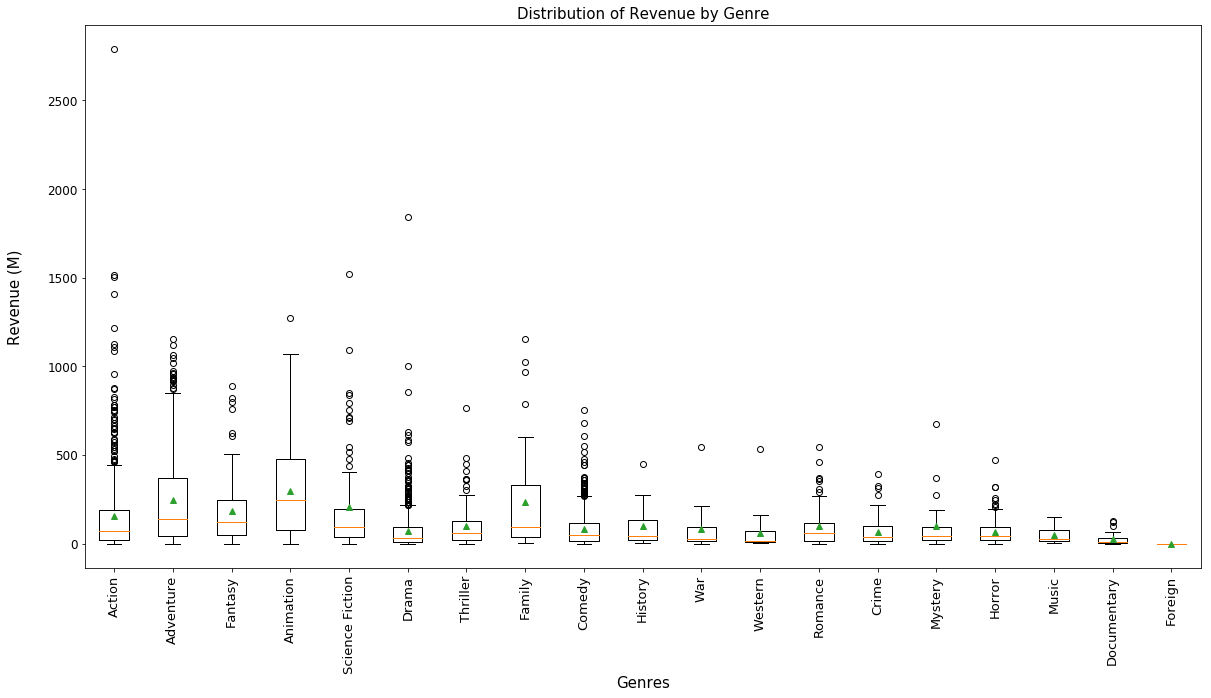

In [71]:
datasets=[]
genres=[]
#i want to iterate over all unique genre
for genr in df_clean_RB['genre_1'].unique():
    rev_per_genre = df_clean_RB.loc[df_clean_RB['genre_1']==genr,'revenue_M'].dropna()
    if pd.isnull(genr):
        pass
    else: 
        datasets.append(rev_per_genre)
    if pd.isnull(genr):
        pass
    else: 
        genres.append(genr)
        
plt.figure(figsize=(20,10))
plt.boxplot(datasets, showmeans=True)
plt.xticks(range(1,len(genres)+1),genres, rotation = 'vertical', fontsize=13)
plt.yticks(fontsize=12)
plt.title('Distribution of Revenue by Genre', fontsize=15)
plt.ylabel('Revenue (M)', fontsize=15, labelpad=25)
plt.xlabel('Genres', fontsize=15,labelpad=2)
plt.show()  

# Question 3- Which actors have the most starring roles? For the top 25 most appearing actors, which actors have the highest average gross and return? 

Similarily to my previous question, I want to look at the top actors, in terms of number of appearances as the top billed actor. 
Does appearing in more movies necesarily mean a higher average gross or average return? 

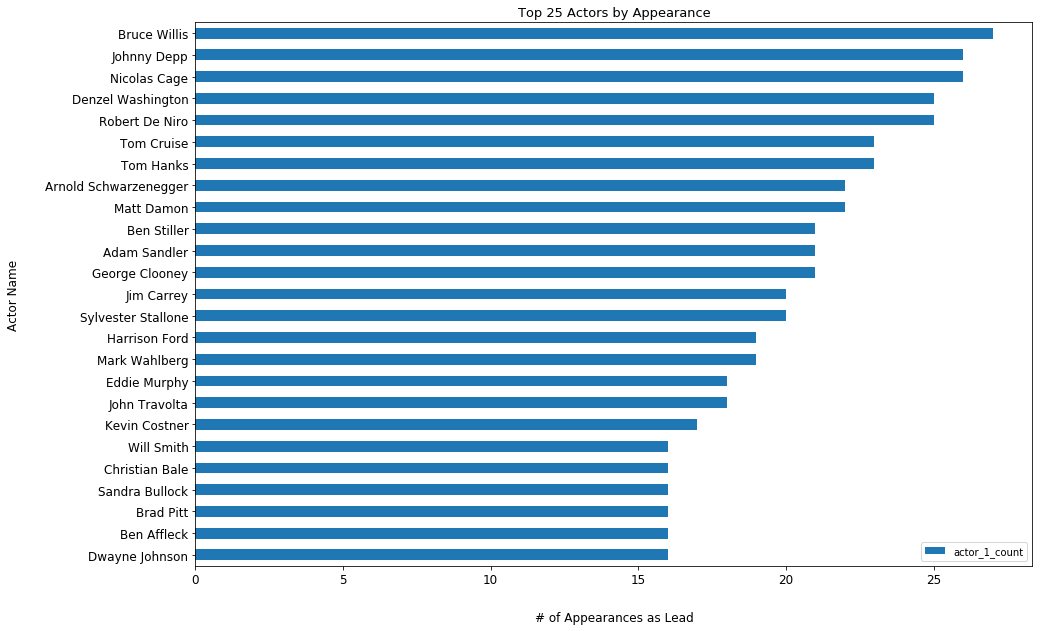

In [69]:
#lets look at the count of the top actors (first billed)

#First, I want to add a counter to my DF, and sum it along with revenue and budget, grouping by actor
df_actor_data = df_clean_RB.copy()
df_actor_data['counter']=1
df_actor_data= pd.DataFrame(df_clean_RB.groupby('actor_1')['revenue_M','budget_M','counter'].agg(['sum']))
df_actor_data.columns =['total_revenue','total_budget','actor_1_count']
df_actor_data['return'] = df_actor_data['total_revenue']/df_actor_data['total_budget']
#In order to keep the same actors when looking at revenue and return, I will sort by count and then revenue to get my top 25
actor_count_top25= df_actor_data.sort_values(['actor_1_count','total_revenue'],ascending =[False,False]).head(25)

count_col = ['actor_1_count']
actor_count_top25.plot.barh(y=count_col, color='#1f77b4')
plt.xlabel('# of Appearances as Lead', fontsize=12, labelpad=25)
plt.ylabel('Actor Name', fontsize=12, labelpad=25)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Top 25 Actors by Appearance", fontsize=13)
plt.rcParams["figure.figsize"] = (15,10)
plt.gca().invert_yaxis()
plt.show()

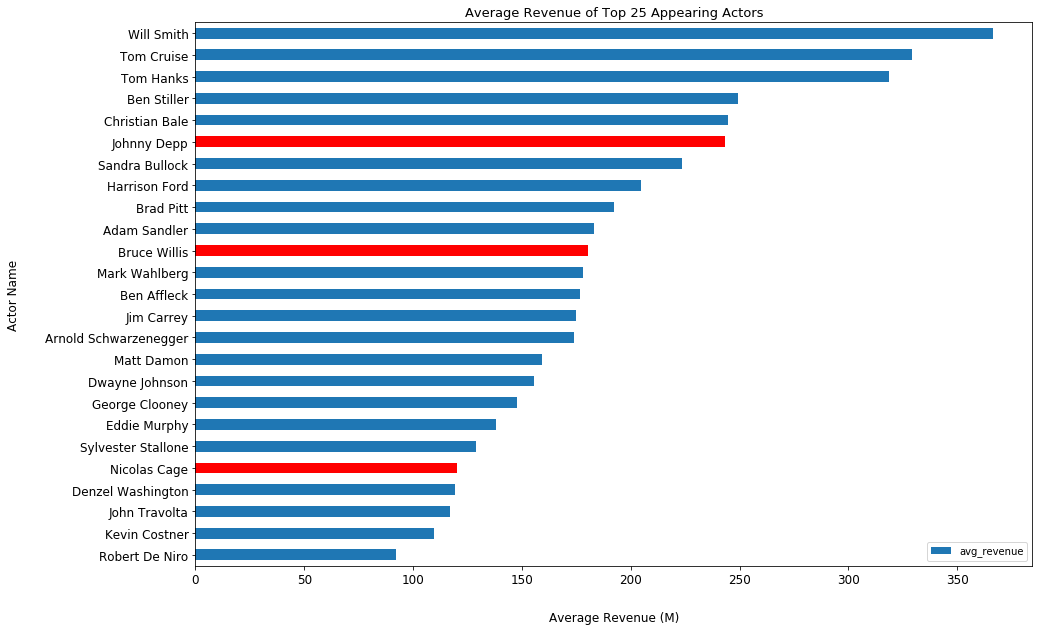

In [73]:
#Bruce William, Nicolas Cage, and Johhny Depp appear in the most films, as top billed actor. 
#But how does the revenue and return compare for the top 25 appearing actors in starring roles? 

#Let's look at average revenue for the top 25 actors. I need to adjust my df to average my revenue. 
df_actor_avg_rev = pd.DataFrame(df_clean_RB.groupby('actor_1')['revenue_M'].agg(['mean','count']).\
                                  rename(columns={'mean':'avg_revenue','count':'actor_1_count'}).dropna())
df_actor_avg_rev = df_actor_avg_rev.sort_values(['actor_1_count','avg_revenue'],ascending =[False,False]).head(25)
df_actor_avg_rev = df_actor_avg_rev.sort_values(['avg_revenue'],ascending =False).reset_index()

#I want to see where the top 3 appearing actors fall in terms of average revenue
df_actor_avg_rev['top_3'] =(df_actor_avg_rev['actor_1']=='Bruce Willis') | \
                                            (df_actor_avg_rev['actor_1']=='Nicolas Cage') | \
                                            (df_actor_avg_rev['actor_1']=='Johnny Depp')

rev_val = ['avg_revenue']
actor_val = ['actor_1']
df_actor_avg_rev.plot.barh(x=actor_val, y=rev_val, color=df_actor_avg_rev.top_3.map({True: 'r', False: '#1f77b4'}))
plt.title("Average Revenue of Top 25 Appearing Actors", fontsize=13)
plt.xlabel('Average Revenue (M)', fontsize=12, labelpad=25)
plt.ylabel('Actor Name', fontsize=12, labelpad=25)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.rcParams["figure.figsize"] = (15,10)
plt.gca().invert_yaxis()
plt.show()


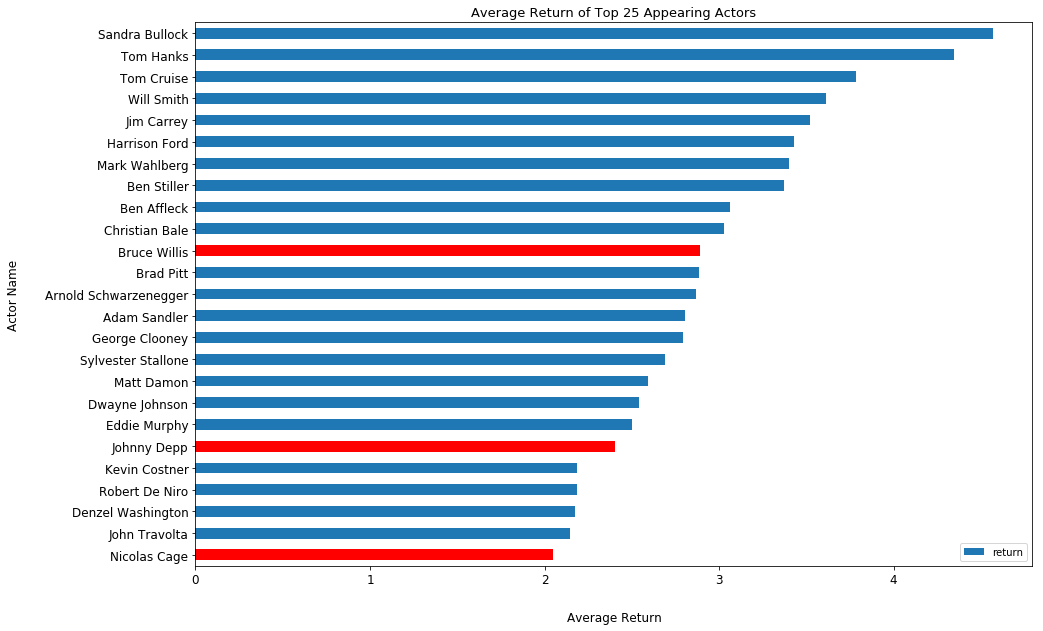

In [74]:
#Will Smith, Tom Cruise, and Tom Hanks are the highest grossing actors, on average, among the top 25 appearing actors. 
#Nicolas Cage falls low on the list, grossing only about 125M on average, despite having the second most starring roles. 

#Let's look at return for the top 25
df_actor_return= df_actor_data.sort_values(['actor_1_count','total_revenue'],ascending =[False,False]).head(25)
df_actor_return= df_actor_return.sort_values(['return'],ascending =False).reset_index()

df_actor_return['top_3'] =(df_actor_return['actor_1']=='Bruce Willis') | \
                                           (df_actor_return['actor_1']=='Nicolas Cage') | \
                                           (df_actor_return['actor_1']=='Johnny Depp')
ret_val = ['return']
actor_val = ['actor_1']
df_actor_return.plot.barh(x=actor_val, y=ret_val, color=df_actor_return.top_3.map({True: 'r', False: '#1f77b4'}))
plt.title("Average Return of Top 25 Appearing Actors", fontsize=13)
plt.xlabel('Average Return', fontsize=12, labelpad=25)
plt.ylabel('Actor Name', fontsize=12, labelpad=25)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.rcParams["figure.figsize"] = (15,10)
plt.gca().invert_yaxis()
plt.show()

So despite having an average gross of 250 M, Johnny Depp falls down the list of the top 25 in terms of return, as does Nicolas Cage. This is not suprising (if you are familiar with the recent work of these actors). 

Meanwhile, Will Smith, Tom Cruise, and Tom Hanks remain at the top of the list , with above average returns. 
Only Sandra Bullock has a higher average return. As the only woman in the list of actors with the most starring roles, this is an intriguing result. I would be interested to see how the returns of other actresses in starrring roles compare to those of men (for future work). 

From this, we can see that just like genres, having more films is not necessarily better, in terms of average gross and return. 
Popularity and ratings also will likely have a large impact on return. 
The less popular or lower rated a movie is, the less likely it will have a good return (take note Johnny and Nicolas), but I would need to verify this with further research. 


# Future Research

As I have mentioned throughout the Capstone, there were a lot of assumptions that needed to be made based on the structure, format, and cleanliness of the data in the movie data set. 

For future research I would like to revisit some of the above questions, digging more into the assumptions that I made. 
Particularly, I would want to look at all genres associated with a film, and see how the aggregrate budgets, grosses, and returns compare, or consider the second or third genre for films with broad genre categories like Drama. With a better sense of all the genres that describe a film, I can revisit my actor analysis to incorporate a genre comaparison by top actors. As I mentioned in question 3, I would also want to conduct a comparison of actors by gender, and perhaps age (data that I would need to include somehow into the data set from outside sources). 

Additionally, per question 1, I would want to further look into the implications of using non-normally distributed data in budget and revenue, and even look into ways of normalizing the data and accounting for outliers. I might want to consider looking at a subset of films, whose budgets and revenue fall above or below a certain threshold. 

Speaking of budget and revenue, I would want to conduct further inquiries on the data provided. Mainly, I would want to confirm whether the dollars reported are normalized for inflation, and for the internationally produced films, whether the dollars reported are converted to US dollars. From this, I can see how the analysis above would change. This also brings up the question of average audience size at the time of film production. Given that the data set contains films as far back as the 1910's, I know that I am working with films of disparate potential audience size. For future work, I might want to limit my dataset to include only films after a certain time period, or the modern day films. 

The movie data set contains so many interesting variables that I can look at, many of which I was not able to explore here. While I looked at actors and genres, I also would love to conduct similar analyses for Directors and Production Companies. Also, here I focused on budget, revenue, and return, but I would also like to dig into the popularity and average voter ratings to identify the most popular types of movies and affinity for certain cast members. This type of analysis could evolve as I progress through the bootcamp. Perhaps to get a true sense of ratings, I could create a webscraper to pull in Rotten Tomato scores (as well as for ages of the actors, as I mentioned above). Ultimately, I would love to create a film recommendation engine from the dataset, to suggest particular movies based on a desired attribute, such as genre, cast, or ratings. This would be something that I could apply everything that I've learned from the bootcamp into creating it. 


# Appendix

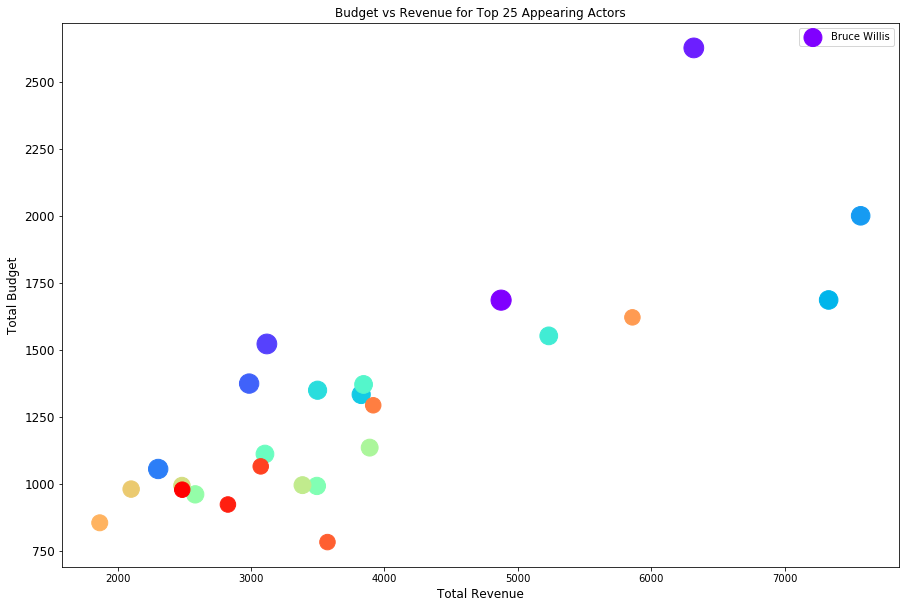

In [75]:

import matplotlib.cm as cm
actor_count_top25= actor_count_top25.reset_index()
colors=cm.rainbow(np.linspace(0, 1, len(actor_count_top25)))
actor_count_top25.plot.scatter(x='total_revenue', y='total_budget', s=actor_count_top25['actor_1_count']*15,c=colors)
plt.title('Budget vs Revenue for Top 25 Appearing Actors')
plt.ylabel('Total Budget')
plt.xlabel('Total Revenue')
plt.legend(actor_count_top25['actor_1'])